# AI Agents in LangGraph
> https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/

## Intro and contents

We will start by building an agent from scratch with just an LLM and Python.

Then learn about the LangGraph components by rebuilding the same agent using the LangGraph components directly.

Learn the capabilities of agentic search and how to use it.

Understand how agents can be written to receive human input to allow you guide an agent at critical points. The second point is persistence, which is the ability to store the current state of information so that you can return to it later. Persistence is key for productionalize an agent.

Future directions for agents and agentic applications.

## Building an agent from scratch

A basic agent is not that hard to build. When building an agent is important to understand the boundaries:
+ which part of the job is done by the LLM
+ which part is managed by the code surrounding the LLM (what we call the runtime).

We'll build an agent following the ReAct pattern which stands for Reasoning + Acting.

In this pattern:
1. The LLM thinks about what to do
2. Then it decides an action to take

The action is executed in an environment, and an observation is returned. With the observation then the LLM repeats and thinks again about what to do again, and decide another action, and continues until it decides it is done.

![ReAct](pics/re_act_agentic_pattern.png)

The code is based in the following post by Simon Willison: https://til.simonwillison.net/llms/python-react-pattern: a great introduction to the ReAct pattern in Python.

We start by importing everything we need:

In [1]:
import re
import os
from dotenv import load_dotenv

_ = load_dotenv()
from openai import AzureOpenAI

Then we initialize the language model:

In [2]:
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2023-12-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)

Let's start by making sure it is working:

In [3]:
chat_completion = client.chat.completions.create(
    model="chat_16k",  # this is the deployment name for GPT 3.5 turbo
    messages=[{"role": "user", "content": "Hello, world!"}],
)

chat_completion.choices[0].message.content

'Hello! How can I assist you today?'

We're set up!

Let's start by creating the agent, by defining a class for the agent.

We want the system to be parameterized by a system message. We'll also want to keep the messages over time.

In [4]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": self.system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(
            model="chat_gpt4o", # deployment name
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content


With the agent implemented, let's now create the ReAct agent.

In [6]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer.
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary.

average_dog_weight:
e.g. average_dog_weight: Collie
Returns average weight of a dog when given the breed.

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dog's weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weighs 51 lbs

You then output:
Answer: A bulldog weighs 51 lbs
""".strip()

We now need to provide the tool mentioned above:

In [7]:
def calculate(what: str):
    return eval(what)

def average_dog_weight(breed: str):
    """mock implementation"""
    if breed in "Scottish Terrier":
        return "Scottish Terriers average 20 lbs"
    elif breed in "Border Collie":
        return "A Border Collie average weight is 37 lbs"
    elif breed in "Toy Poodle":
        return "A Toy Poodle average weight is 7 lbs"
    else:
        return "An average dog weight is 50 lbs"

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight,
}

Now let's try it out by instantiating the agent with the prompt created above:

In [8]:
abot = Agent(prompt)

Let's call it once with an initial question:

In [9]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the average weight of a toy poodle using the average_dog_weight action.
Action: average_dog_weight: Toy Poodle
PAUSE


Let's do what the agent suggests:

In [10]:
result = average_dog_weight("Toy Poodle")
result

'A Toy Poodle average weight is 7 lbs'

We can now format that into the next prompt to pass to the language model:

In [11]:
next_prompt = f"Observation: {result}"

Now we can call the agent with that next prompt:

In [12]:
abot(next_prompt)

'Answer: A Toy Poodle weighs an average of 7 lbs.'

Note that the agent returns the Answer.

We can take a look at the `messages` attribute on the agent to understand what has happened:

In [13]:
abot.messages

[{'role': 'system',
  'content': "You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer.\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary.\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nReturns average weight of a dog when given the breed.\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dog's weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weighs 51 lbs\n\nYou then output:\nAnswer: A bulldog weighs 51 lbs"},
 {'role': 'user', 'content': 'How much does a 

Let's try again with a different example.

Note that we will need to reinitialize the agent to clear all the messages already accumulated from the previous execution.

Also, this time we will ask a more complicated question:

In [14]:
abot = Agent(prompt)

In [15]:
question = """
I have 2 dogs, a border collie and a scottish terrier.
What is their combined weight?
"""
abot(question)

'Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then sum these weights to get the combined weight.\n\nAction: average_dog_weight: Border Collie\nPAUSE'

Note that the plan is a really good one:
> Find the average weight of both dogs, then add them together.

The first action then should be to call average_dog_weight with "Border Collie".

Let's execute that action:

In [16]:
next_prompt = f"Observation: {average_dog_weight('Border Collie')}"
print(next_prompt)

Observation: A Border Collie average weight is 37 lbs


I can now call the agent on this next prompt:

In [17]:
abot(next_prompt)

'Thought: Now I need to find the average weight of a Scottish Terrier.\n\nAction: average_dog_weight: Scottish Terrier\nPAUSE'

Now we need to execute a different action. Let's do so:

In [18]:
next_prompt = f"Observation: {average_dog_weight('Scottish Terrier')}"
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


And we can call the agent again with this prompt:

In [19]:
abot(next_prompt)

'Thought: I now have the average weights of both dogs. I will sum these weights to get the combined weight.\n\nAction: calculate: 37 + 20\nPAUSE'

Now the agent has identified the next action, which is to calculate the sum of the average weights of both breeds:

In [20]:
next_prompt = f"Observation: {calculate('37 + 20')}"
print(next_prompt)

Observation: 57


Now we send the next prompt yet again to the agent:

In [21]:
abot(next_prompt)

'Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.'

Now the agent tells us that the cycle is complete, as it has reached the final answer.

Now that we have developed an intuition about how the ReAct pattern and the agent works, let's automate it by putting the manual steps in a loop.

Let's start by creating a regex that will look for the action string. This will let us parse the LLM's response and determine whether we should be taking an action, or whether the agent has reached the final answer.

In [23]:
action_re = re.compile(r"^Action: (\w+): (.*)$")

Let's now create the query function that automates the process:

In [24]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) for a in result.split("\n") if action_re.match(a)
        ]
        if actions:
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception(f"Unknown action: {action}: {action_input}")
            print(f">> running {action}: {action_input}")
            observation = known_actions[action](action_input)
            print(f">> Observation: {observation}")
            next_prompt = f"Observation: {observation}"
        else:
            # agent has reached the answer
            return

Let's now try our automated workflow:

In [25]:
question = """
I have 2 dogs, a border collie and a scottish terrier.
What is their combined weight?
"""
query(question)

Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then sum these weights to get the combined weight of the two dogs.
Action: average_dog_weight: Border Collie
PAUSE
>> running average_dog_weight: Border Collie
>> Observation: A Border Collie average weight is 37 lbs
Thought: I now need to find the average weight of a Scottish Terrier.
Action: average_dog_weight: Scottish Terrier
PAUSE
>> running average_dog_weight: Scottish Terrier
>> Observation: Scottish Terriers average 20 lbs
Thought: I now have the average weights of both dogs. I need to sum these weights to get the combined weight.
Action: calculate: 37 + 20
PAUSE
>> running calculate: 37 + 20
>> Observation: 57
Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.


So we've seen how to create an agent using nothing but the raw LLM API and some Python code.

We'll see how to implement the same agent using LangGraph.

## LangGraph Components

Let's break down what we did in the previous section into LangChain components.

The high-level diagram for the process is the following:

![reAct process](pics/re_act_process.png)

First, we have the prompts. As we know, `PromptTemplate` allows you to build reusable prompts.

`PromptTemplate` allows you to use a prompt with formatted variables that you can replace with user content.

```python
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template(
    "Tell me a {adjective} joke about {content}"
)
```

And you can also use prompts from the LangChain hub:

```python
from langchain import hub
prompt = hub.pull("hwchase17/react")
```

This will pull a prompt very similar to the one we wrote, but with variable content:

https://smith.langchain.com/hub/hwchase17/react

```
Answer the following questions as best you can. You can have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer.
Thought: you should always think about what to do.
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action

...(this Thought/Action/Action Input/Observation can repeat N times)
Thought I now know the final answer.
Final Answer: the final answer to the original input question.

Begin!

Question: {input}
Thought: {agent_scratchpad}
```

The second component we have in LangChain it's tools.

You have a set of readily available tools that you can use to perform complex actions, such as getting search results using [Tavily](https://tavily.com/).

As it reads on the website, Tavily Search API is a search engine optimized for LLMs and RAG, aimed at efficient, quick, and persistent search results.

We can use Tavily Search by doing:

```python
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max, results=2)
self.tools = {t.name for t in tools}
self.model = model.bind_tools([tool])
```

The community package contains hundreds of other tools.

LangGraphs helps you describe and orchestrate the control flow (the arrows) from the diagram above.

It allows you to create cyclic graph. It has built-in persistence to remember all previous iterations and actions.

Additionally, the persistence enbales human-in-the-loop features.

LangGraph is an extension of LangChain that supports graphs.
+ Single and multi-agent flows are described and represented as graphs.
+ Allows for extremely controlled flows, which is critical to create agents that can perform well.
+ It provides built-in persistence that allows for human-in-the-loop workflows.



Three of the core concepts of LangGraph are:

+ Nodes: agents or functions
+ Edges: connect nodes
+ Conditional edges: for decisions

The equivalent for the function we created in the previous section would be:

![LangGraph diagram](pics/langgraph_graph.png)

Regarding the Data/State

The Agent State is accessible to all parts of the graph.

+ It is local to the graph
+ Can be stored in a persistence layer

![LangGraph state](pics/langgraph_state.png)


At its simplest form, it can implemented as a list of messages:

```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
```

`BaseMessage` is a LangChain object. The type `Annotated[Sequence[BaseMessage], operator.add]` means that messages is a sequence of messages and when the state is updated with new messages it doesn't overwrite but rather adds them to create the new state.

A more complicated state would look like the following:

```python
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
```



In detail, if we want to implement the same exercise as before we will have:

1. An agent node that we will call `call_openai` that will be in charge of calling the LLM.
2. We will have a conditional edge that will check for the existence of an action to take. We will call this `exist_action`.
3. We will have another node that will execute the action and that we will call `take_action`.

Finally, the state can be tracked with:

```python
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
```

Thus, the annotated diagram will be:

![LangChain: annotated use case diagram](pics/langchain_annotated_usecase.png)


Let's dive into the code:

Let's make sure we have loaded all the environment variables required to interact with OpenAI:

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

Now we import a bunch of things that we need to create all the components:

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

Let's first have a look at the tool:

In [3]:
tool = TavilySearchResults(max_results=2)
print(f"Tool type: {type(tool)}")
print(f"Tool name: {tool.name}")

Tool type: <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
Tool name: tavily_search_results_json


Now we create the agent state, annotated in a way that LangChain can understand that it is a list of messages that we will add to over time.

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

Now, we create the Agent class with three methods representing the three actions:

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
            message = self.model.invoke(messages)
            return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f">> calling: {t}")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result)))
        print(">> back to the model")
        return {'messages': results}

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

Now we create a system prompt and initialize the underlying model:

In [11]:
prompt = """
You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = AzureChatOpenAI(
    openai_api_version="2023-05-15",
    azure_deployment="chat_gpt4o",
    model="gpt-4o",
    temperature=0
)

abot = Agent(model, [tool], system=prompt)

We can visualize the graph we've just created:

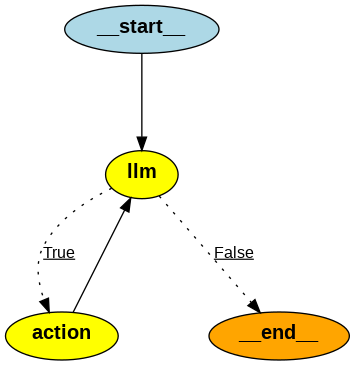

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

Let's now call this agent:

In [12]:
messages = [HumanMessage(content="What is the weather in Luengos de los Oteros, Spain")]
result = abot.graph.invoke({"messages": messages})

>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Luengos de los Oteros, Spain'}, 'id': 'call_tcofQbepWB4MxOG8aOAgqSA4', 'type': 'tool_call'}
>> back to the model


If we now look at result, we can see a list of messages.

`result` is the final state that the agent ended up with.

In [13]:
result

{'messages': [HumanMessage(content='What is the weather in Luengos de los Oteros, Spain'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tcofQbepWB4MxOG8aOAgqSA4', 'function': {'arguments': '{"query":"current weather in Luengos de los Oteros, Spain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 159, 'total_tokens': 188}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-88b3edbc-0e38-4679-b290-c4a78c0b1f0e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Luengos de los Oteros, Spain'}, 'id': 'call_tcofQbepWB4MxOG8aOAgqSA4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 29, 'total_tokens': 188}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'locat

If we just want to get the final message we can go to the messages atrribute and look at the content of the last message:

In [14]:
result["messages"][-1].content

'The current weather in Luengos de los Oteros, Spain is as follows:\n\n- **Temperature**: 31.9°C (89.4°F)\n- **Condition**: Sunny\n- **Wind**: 9.0 kph (5.6 mph) from the southwest\n- **Humidity**: 16%\n- **Pressure**: 1008.0 mb\n- **Visibility**: 10 km (6 miles)\n- **UV Index**: 8\n\nIt feels like 29.6°C (85.4°F) due to the low humidity.'

Let's try the agent with a more complicated question:

In [15]:
messages = [HumanMessage(content="What is the weather in Madrid and Mansilla de las Mulas, Spain?")]
result = abot.graph.invoke({"messages": messages})

>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Madrid, Spain'}, 'id': 'call_XMWJkEPg2Kbpw7bIz4Mqv9TW', 'type': 'tool_call'}
>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Mansilla de las Mulas, Spain'}, 'id': 'call_bkUxHAaN7QUWPislC2o9ZZdJ', 'type': 'tool_call'}
>> back to the model


See that now the model performs a parallel function call: it uses the tool twice to get the weather in Madrid and Mansilla before getting back to the model.

With all the information in place, the agent can now craft the final answer:

In [16]:
result["messages"][-1].content

'### Current Weather in Madrid, Spain:\n- **Temperature:** 36.7°C (98.1°F)\n- **Condition:** Sunny\n- **Wind:** 15.5 kph (9.6 mph) from the WSW\n- **Humidity:** 10%\n- **Visibility:** 10 km (6 miles)\n- **UV Index:** 9\n- **Feels Like:** 35.3°C (95.6°F)\n\n### Current Weather in Mansilla de las Mulas, Spain:\n- **Temperature:** 25.7°C (78.3°F)\n- **Condition:** Sunny\n- **Wind:** 24.5 kph (15.2 mph) from the North\n- **Humidity:** 48%\n- **Visibility:** 10 km (6 miles)\n- **UV Index:** 7\n- **Feels Like:** 26.3°C (79.3°F)\n\nBoth locations are experiencing sunny weather, with Madrid being significantly warmer than Mansilla de las Mulas.'

We can try with an even more complicated question?

In [21]:
query = "Who won La Liga in 2024? What is the population of that region?"
messages=[HumanMessage(content=query)]
result = abot.graph.invoke({"messages": messages})

>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'La Liga 2024 winner'}, 'id': 'call_FK8izxyL9nSDoXq1BVNV2EAD', 'type': 'tool_call'}
>> back to the model
>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'population of Madrid 2024'}, 'id': 'call_Z92vH7DLASITheABMdgeGK5M', 'type': 'tool_call'}
>> back to the model


We see that first it searches the winner of La Liga, and then it searches for the GDP of the associated region:

In [22]:
result["messages"][-1].content

'Real Madrid won La Liga in the 2023-2024 season. The population of the Madrid metropolitan area in 2024 is projected to be approximately 6,783,000.'

Note that in this case, the model could not implement a parallel search, as it required the answer from the first query to run the second one.

## Agentic Search Tools

Agentic search is different from a regular search.

The agentic search includes multiple steps that do not only perform the search, but also navigates the links to bring the results.

In [6]:
from dotenv import load_dotenv
import os
from tavily import TavilyClient

_ = load_dotenv()

client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

result = client.search("When will Openheimer be available in Netflix?", include_answer=True)
result["answer"]

'Oppenheimer will not be available on Netflix in the US until at least 2027, as per the latest information available.'

Another example:

In [7]:
city = "Madrid"

query = f"""
What is the weather in {city}?
Should I travel there today?
"""

result = client.search(query, max_results=1)
data = result["results"][0]["content"]

In [8]:
print(data)

{'location': {'name': 'Madrid', 'region': 'Madrid', 'country': 'Spain', 'lat': 40.4, 'lon': -3.68, 'tz_id': 'Europe/Madrid', 'localtime_epoch': 1723017842, 'localtime': '2024-08-07 10:04'}, 'current': {'last_updated_epoch': 1723017600, 'last_updated': '2024-08-07 10:00', 'temp_c': 31.4, 'temp_f': 88.5, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 4.3, 'wind_kph': 6.8, 'wind_degree': 89, 'wind_dir': 'E', 'pressure_mb': 1012.0, 'pressure_in': 29.88, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 22, 'cloud': 0, 'feelslike_c': 29.4, 'feelslike_f': 85.0, 'windchill_c': 31.4, 'windchill_f': 88.5, 'heatindex_c': 29.4, 'heatindex_f': 85.0, 'dewpoint_c': 7.4, 'dewpoint_f': 45.2, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 8.0, 'gust_mph': 4.9, 'gust_kph': 7.9}}


Note how the agentic search does not return what a human would want, but returns structure data, which is exactly what an agent would want.

## Persistence and Streaming

Persistence lets you keep the state of an agent at a particular point in time, so so that you can potentially go back to that state and resume in that state for future interactions.

Streaming lets you emit a list of signals of what's going on at that exact moment.

Both are important for long-running applications in which you need to know what the agent is doing.

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=2)

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

Now, before defining our agent we'll add persistence.

For that, we need another component called a *check pointer* that essentially checkpoints the state after and between every node.

We'll use the simple `SqliteSaver` checkpointer that uses Sqlite under the hood. We'll configure it with the in-memory option:

In [5]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

Now we make the necessary changes to make the agent aware of the checkpointer:

In [7]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f">> calling: {t}")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result)))
        print(">> back to the model")
        return {"messages": results}


We can now create our agent

In [9]:
prompt = """
You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = AzureChatOpenAI(
    openai_api_version="2023-05-15",
    azure_deployment="chat_gpt4o",
    model="gpt-4o",
    temperature=0
)

abot = Agent(model, [tool], system=prompt, checkpointer=memory)

Now we're going to add the streaming capabilities.

There are two different dimensions to consider:
+ streaming the individual messages. This would be the AI message that determines what action to take, and the observation message that represents the result of taking a given action.
+ streaming the tokens. This means stream the output of the LLM call.

Let's start configuring the message streaming.

Let's start by creating a human message and add the concept of a thread config:

In [8]:
messages = [HumanMessage(content="What is the weather Luengos de los Oteros, near Santas Martas, in León, Spain?")]

This keep tracks of different threads inside the persistence checkpointer so that we can have multiple conversations going on at the same time (which is needed for production apps with many users).

The thread config is just a dictionary with a configurable key.

In [9]:
thread = {"configurable": {"thread_id": "1"}}

Now we're going to call the graph with `stream` instead of `invoke` passing the messages and the thread config:

In [10]:
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v["messages"])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_F6IWm0oGszECYN0BcFSGA6u3', 'function': {'arguments': '{"query":"current weather in Luengos de los Oteros, near Santas Martas, León, Spain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 168, 'total_tokens': 205}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-cd8a4907-b18e-4b6e-9fd8-cd6c1fa98dc3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Luengos de los Oteros, near Santas Martas, León, Spain'}, 'id': 'call_F6IWm0oGszECYN0BcFSGA6u3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 37, 'total_tokens': 205})]
>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Luengos de los Oteros, near Santas Marta

Because we have persistence, we can now do:

In [11]:
messages = [HumanMessage(content="And in León, Spain?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v["messages"])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2GJ87S0Yr7StPsvYQfBM94FT', 'function': {'arguments': '{"query":"current weather in León, Spain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 848, 'total_tokens': 871}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-0ff13007-76e2-45f1-8ef2-7befb34f6b9a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in León, Spain'}, 'id': 'call_2GJ87S0Yr7StPsvYQfBM94FT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 848, 'output_tokens': 23, 'total_tokens': 871})]
>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in León, Spain'}, 'id': 'call_2GJ87S0Yr7StPsvYQfBM94FT', 'type': 'tool_call'}
>> back to the model
[ToolMessage(content='[{\'url\

Note that we didn't have to include the context about the whether, because the agent has all the state persisted and knows that we were asking about the weather.

But we can even performed more sophisticated questions:

In [12]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v["messages"])

[AIMessage(content='León, Spain is currently warmer than Luengos de los Oteros, near Santas Martas, León, Spain.\n\n- **León**: 31.4°C (88.5°F)\n- **Luengos de los Oteros**: 25.0°C (76.9°F)', response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 1470, 'total_tokens': 1536}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-855a940d-14bf-49ec-a940-691924d08102-0', usage_metadata={'input_tokens': 1470, 'output_tokens': 66, 'total_tokens': 1536})]


Note as well, that if we change the thread config, the agent will not know how to answer: 

In [13]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v["messages"])

[AIMessage(content='Could you please provide more context or specify the items or locations you are comparing in terms of warmth? This will help me give you a more accurate answer.', response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 150, 'total_tokens': 182}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-a0479edd-1f58-462e-8b00-e2f316186577-0', usage_metadata={'input_tokens': 150, 'output_tokens': 32, 'total_tokens': 182})]


To stream tokens we will need to change the implementation of the checkpointer, to use an async one:

In [10]:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

memory = AsyncSqliteSaver.from_conn_string(":memory:")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

Now we can start using the async methods:

In [12]:
messages = [HumanMessage(content="What is the weather Luengos de los Oteros, near Santas Martas, in León, Spain?")]
thread = {"configurable": {"thread_id": "5"}}
async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # we only print the non-empty content
            # (content will be emptyif the model is asking for a tool to be invoked)
            print(content, end="|")


>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather Luengos de los Oteros, near Santas Martas, León, Spain'}, 'id': 'call_HB8aT455wzdYEIB8vyZ93lgT', 'type': 'tool_call'}
>> back to the model
The| current| weather| in| Lu|eng|os| de| los| O|teros|,| near| Sant|as| Mart|as|,| León|,| Spain| is| as| follows|:

|-| **|Temperature|**|:| |26|.|8|°C| (|80|.|3|°F|)
|-| **|Condition|**|:| Sunny|
|-| **|Wind|**|:| |7|.|2| k|ph| (|4|.|5| mph|)| from| the| southeast|
|-| **|Humidity|**|:| |38|%
|-| **|Pressure|**|:| |101|4|.|0| mb|
|-| **|Visibility|**|:| |10| km| (|6| miles|)
|-| **|UV| Index|**|:| |7|

|The| weather| is| clear| with| minimal| cloud| cover| (|5|%).|

In summary:
+ you're going to want your agents to be able to have multiple conversations at the same time and have the concept of memory so that they can resume those conversations.
+ You're going to want your agents to stream both the final tokens and the messages that came before.

Persistence is also important for enabling "human in the loop" type interactions.

## Human in the loop

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

For this human in the loop interactions we want to replace existing messages.

We will use a custom reducer for message that will basically look for messages with the same ID and if it sees that you're inserting one with the same ID as one that already exists, it's just going to replace that. Otherwise it will append them.

In [3]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [4]:
tool = TavilySearchResults(max_results=2)

In the agent we will introduce a small modification in which we will pass `interrupt_before=["action"]` when instantiating the agent.

This is going to add an interrupt before we call the action node, and the action node is where we call the tools.

The idea is to add something that requires manual approval before we run any tools. This might be useful to make sure that tools are executed correctly.

In [5]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f">> calling: {t}")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result)))
        print(">> back to the model")
        return {"messages": results}


Now we initialize the agent:

In [6]:
prompt = """
You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = AzureChatOpenAI(
    openai_api_version="2023-05-15",
    azure_deployment="chat_gpt4o",
    model="gpt-4o",
    temperature=0
)

abot = Agent(model, [tool], system=prompt, checkpointer=memory)

And call it:

In [7]:
messages = [HumanMessage(content="What is the weather Luengos de los Oteros, near Santas Martas, in León, Spain?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='What is the weather Luengos de los Oteros, near Santas Martas, in León, Spain?', id='1803c8e0-f64f-4c2d-a80b-6f205e4669cd'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gKdQhx57MzGdMH1eGI9HBu0d', 'function': {'arguments': '{"query":"current weather in Luengos de los Oteros, near Santas Martas, León, Spain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 168, 'total_tokens': 205}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-9b8e50bc-43ae-41f1-bd8a-e6544949afbd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Luengos de los Oteros, near Santas Martas, León, Spain'}, 'id': 'call_gKdQhx57MzGdMH1eGI9HBu0d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_token

Check how we stop after the AIMessage, because the AI message is telling us to call a tool.

We can get the current state of the graph for this thread at this point in time:

In [33]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather Luengos de los Oteros, near Santas Martas, in León, Spain?', id='f261c403-38a0-472b-ab67-a5def96534f8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JIF8OHzZjdrhMJadJMkxas8E', 'function': {'arguments': '{"query":"current weather Luengos de los Oteros, near Santas Martas, León, Spain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 168, 'total_tokens': 204}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-58e12fc6-2719-4bd3-ad9b-796f3a58cfe0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather Luengos de los Oteros, near Santas Martas, León, Spain'}, 'id': 'call_JIF8OHzZjdrhMJadJMkxas8E', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168

We can also use next to understand what we should be doing next:

In [34]:
abot.graph.get_state(thread).next

('action',)

This means we're about to call the action node.

In order to continue we can just call stream passing `None` as the input (instead of messages):

In [35]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather Luengos de los Oteros, near Santas Martas, León, Spain'}, 'id': 'call_JIF8OHzZjdrhMJadJMkxas8E', 'type': 'tool_call'}
>> back to the model
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Santas Martas\', \'region\': \'Castilla y Leon\', \'country\': \'Spain\', \'lat\': 42.43, \'lon\': -5.37, \'tz_id\': \'Europe/Madrid\', \'localtime_epoch\': 1723026360, \'localtime\': \'2024-08-07 12:26\'}, \'current\': {\'last_updated_epoch\': 1723025700, \'last_updated\': \'2024-08-07 12:15\', \'temp_c\': 28.4, \'temp_f\': 83.2, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 5.6, \'wind_kph\': 9.0, \'wind_degree\': 165, \'wind_dir\': \'SSE\', \'pressure_mb\': 1013.0, \'pressure_in\': 29.91, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 32, 

See how we get the final AIMessage with the response.

And if we ask about any pending things, we see it's an empty set:

In [36]:
abot.graph.get_state(thread).next

()

This means there's nothing left to be done.

One simplistic way to involve the user would be to automate the whole approval process in a loop:

In [8]:
messages = [HumanMessage(content="What's the population of León, Spain?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print(abot.graph.get_state(thread))
    user_input = input("Proceed? [y/n]")
    if user_input.lower() != "y":
        print("Process aborted by the user")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)
print("-- finished --")

{'messages': [HumanMessage(content="What's the population of León, Spain?", id='fb1780c4-82a5-413c-bfef-97a18496b844'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_czteb9mmonzOhOT6bp2GsyMH', 'function': {'arguments': '{"query":"current population of León, Spain 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 153, 'total_tokens': 179}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-7e62fa21-3ab8-4299-b3f6-464cbd5d4923-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current population of León, Spain 2023'}, 'id': 'call_czteb9mmonzOhOT6bp2GsyMH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 26, 'total_tokens': 179})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'c

You see that we're getting `StateSnapshot` with certain information about the state of the graph.

As a graph is executing, a snapshot of each state is stored in memory.

![State Memory](pics/state_memory.png)

A snapshot is a container for the agent state along with some other useful things, such as the thread and a unique identifier for each of the snapshots.

The information for the state memory can be accessed with certain methods:

```python
# config = {"configurable": {"thread_id": "1"}}

# returns current state in the given thread (state 3 in the pic above)
g.get_state(thread)

# returns a particular state in the given thread (state 1 in the pic above)
g.get_state({thread, thread_ts="<uuid-for-state1>"})


# returns an iterator over all StateSnapshots, that is,
# an iterator over State3 through State0
g.get_state_history(thread)
```

Using these methods will let you do a little bit of time travel, such as accessing State 1 and use it as a starting point for certain things.

```python
state1 = g.get_state({thread, thread_ts})
g.invoke(None, state1)
g.stream(None, state1)
```

Note that you can also retrieve a particular state, modify it, and then update it so that it is used in a different way:

```python
# get state
state1 = g.get_state({thread, thread_ts})

# modify the state
state1m = ...state1 modified...

# update the state
g.update_state(thread, state1m.values)
```

Thus, whenevery you run `g.stream(None, thread)` it will use the modified state.

Let's see an example of how to modify a state:

In [9]:
messages = [HumanMessage(content="What is the weather in Leon?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='What is the weather in Leon?', id='d252dc4f-8e6f-4a25-8feb-71cf13df094a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'function': {'arguments': '{"query":"current weather in Leon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-adb49d12-5815-4c9e-b6be-bce62908c9cd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon'}, 'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'functio

We can use `get_state` to get the latest StateSnapshot for the given thread:

In [10]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in Leon?', id='d252dc4f-8e6f-4a25-8feb-71cf13df094a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'function': {'arguments': '{"query":"current weather in Leon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-adb49d12-5815-4c9e-b6be-bce62908c9cd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon'}, 'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef558b2-8aea-6a78-80

Let's pretend that we're interested in the weather in Leon, Spain, rather than in Leon, MX.

We could correct the human message and change the AI action doing:

In [11]:
current_values = abot.graph.get_state(thread)
current_values.values["messages"][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'function': {'arguments': '{"query":"current weather in Leon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-adb49d12-5815-4c9e-b6be-bce62908c9cd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon'}, 'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})

We can drill down even further to see the list of tool calls associated with the message:

In [12]:
current_values.values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Leon'},
  'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV',
  'type': 'tool_call'}]

Let's update the state:

In [15]:
id = current_values.values["messages"][-1].tool_calls[0]["id"]
current_values.values["messages"][-1].tool_calls = [
    {
        "name": "tavily_search_results_json",
        "args": {
            "query": "current weather in Leon, Spain"
        },
        "id": id
     }
]

abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='What is the weather in Leon?', id='d252dc4f-8e6f-4a25-8feb-71cf13df094a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'function': {'arguments': '{"query":"current weather in Leon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-adb49d12-5815-4c9e-b6be-bce62908c9cd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon, Spain'}, 'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}


{'configurable': {'thread_id': '3',
  'thread_ts': '1ef558c5-6622-6206-8002-8e40cbb22b72'}}

If we now get the current state, we'll see:

In [16]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in Leon?', id='d252dc4f-8e6f-4a25-8feb-71cf13df094a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'function': {'arguments': '{"query":"current weather in Leon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-adb49d12-5815-4c9e-b6be-bce62908c9cd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon, Spain'}, 'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef558c5-6622-

We can see near the end of the JSON that we're actually querying the weather in Leon Spain.

If we now do:

In [17]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon, Spain'}, 'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'type': 'tool_call'}
>> back to the model
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Leon\', \'region\': \'Castilla y Leon\', \'country\': \'Spain\', \'lat\': 42.6, \'lon\': -5.57, \'tz_id\': \'Europe/Madrid\', \'localtime_epoch\': 1723124711, \'localtime\': \'2024-08-08 15:45\'}, \'current\': {\'last_updated_epoch\': 1723124700, \'last_updated\': \'2024-08-08 15:45\', \'temp_c\': 34.1, \'temp_f\': 93.4, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 6.7, \'wind_kph\': 10.8, \'wind_degree\': 188, \'wind_dir\': \'S\', \'pressure_mb\': 1013.0, \'pressure_in\': 29.91, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 16, \'cloud\': 3, \'feelslike_c\': 32.1, \'feelslike_f\

We see that we get the value of the weather in Leon, Spain.

Note that when we modified the state, we actually created a new state, and that became the new state. This is nice because it let us keep track of the whole history.

In [18]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print("---")
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in Leon?', id='d252dc4f-8e6f-4a25-8feb-71cf13df094a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'function': {'arguments': '{"query":"current weather in Leon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-adb49d12-5815-4c9e-b6be-bce62908c9cd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon, Spain'}, 'id': 'call_fEMDOZ4dNuJLNFoyPTcn82nV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\

We can get the original state, the one that was asking for the weather in Leon without specifying Spain or Mexico:

In [19]:
to_replay = states[-1]
to_replay

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef558b2-7de3-6271-bfff-83e4d2395c2f'}}, metadata={'source': 'input', 'writes': {'messages': [HumanMessage(content='What is the weather in Leon?')]}, 'step': -1}, created_at='2024-08-08T13:36:02.946301+00:00', parent_config=None)

To resume the graph from that original state, to see whether it would have retrieved the weather from Leon Spain or Leon Mexico, we just need to inject that state:

In [20]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='What is the weather in Leon?', id='d252dc4f-8e6f-4a25-8feb-71cf13df094a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wynHFQroUAHC1mZ7OMyzsf3j', 'function': {'arguments': '{"query":"current weather in Leon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-9299e0f6-2410-48f2-8e56-8c954e8b4b0f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon'}, 'id': 'call_wynHFQroUAHC1mZ7OMyzsf3j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wynHFQroUAHC1mZ7OMyzsf3j', 'functio

In [21]:
# need to continue as it stops before calling the tool
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

>> calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Leon'}, 'id': 'call_wynHFQroUAHC1mZ7OMyzsf3j', 'type': 'tool_call'}
>> back to the model
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Leon\', \'region\': \'Guanajuato\', \'country\': \'Mexico\', \'lat\': 21.12, \'lon\': -101.67, \'tz_id\': \'America/Mexico_City\', \'localtime_epoch\': 1723125181, \'localtime\': \'2024-08-08 07:53\'}, \'current\': {\'last_updated_epoch\': 1723124700, \'last_updated\': \'2024-08-08 07:45\', \'temp_c\': 16.5, \'temp_f\': 61.7, \'is_day\': 1, \'condition\': {\'text\': \'Patchy rain nearby\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/176.png\', \'code\': 1063}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 157, \'wind_dir\': \'SSE\', \'pressure_mb\': 1014.0, \'pressure_in\': 29.94, \'precip_mm\': 0.01, \'precip_in\': 0.0, \'humidity\': 68, \'cloud\': 85, \'feelslike_c\': 16.5, 

And we see that it was retrieving the weather from Leon Mexico.

We can modify the state from that initial state too, the steps are exactly the same

In [22]:
# are you still there?
to_replay

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef558b2-7de3-6271-bfff-83e4d2395c2f'}}, metadata={'source': 'input', 'writes': {'messages': [HumanMessage(content='What is the weather in Leon?')]}, 'step': -1}, created_at='2024-08-08T13:36:02.946301+00:00', parent_config=None)

In [23]:
# this fails because the messages are empty, but the process is the same
id = to_replay.values["messages"][-1].tool_calls[0]["id"]
to_replay.values["messages"][-1].tool_calls = [
    {
        "name": "tavily_search_results_json",
        "args": {
            "query": "current weather in Leon, Spain, accuweather"
        },
        "id": id
     }
]

IndexError: list index out of range

So we've actual branched off from a previous step.

Another thing we can do is add messages to a given state. That might be needed to mock out a response.

In [24]:
id = to_replay.values["messages"][-1].tool_calls[0]["id"]
state_update = {
    "messages": [
        ToolMessage(
            tool_call_id=id,
            name="tavily_search_results_json",
            content="54 degrees celsius and sunny as hell",
        )
    ]
}

IndexError: list index out of range

This will append it instead of modifying the existing.

In order to add it, you need to do:

In [ ]:
branch_and_add = abot.graph.update_state(
    to_replay.config,
    state_update,
    as_node="action"  # update as if we were the action node
)

Then you can do:

In [ ]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

In summary you can have human-in-the-loop interactions for:

+ approve or deny the execution of a specific action
+ go back in time
+ modify the state (either last state or previous state)
+ let a human give the result of calling a tool

## A complicated use case: Essay Writer

In this section we'll build a compact version of an AI researcher.

The following graph describes the approach that we will follow:

![Essay Writer Graph](pics/essay_writer_graph.png)

Let's start with loading the configuration and importing the things we need:

In [26]:
from dotenv import load_dotenv
_ = load_dotenv()

from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

Now we're going to create the agent state, which will be a little bit more complicated than before:

In [27]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [28]:
model = AzureChatOpenAI(
    openai_api_version="2023-05-15",
    azure_deployment="chat_gpt4o",
    model="gpt-4o",
    temperature=0
)

In [29]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes
or instructions for the sections."""

In [30]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed:

------

{content}"""

In [31]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc."""


In [32]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can
be used when writing the following essay. Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

In [33]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

We're going to use function calling to ensure that we get back a list of strings from the language model.

In order to do so, we set up a Pydantic model that will represent the result that we want to get back from invoking the language model:

In [34]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

Now we import the TavilyClient instead of the tool because we're working on a slightly unconventional way:

In [35]:
from tavily import TavilyClient
import os
tavily = TavilyClient()

Now we can start creating all our different agents (==all our different nodes).

Let's start with the one that does the planning:

In [36]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

Now, we can define the agent that does some research:

In [37]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ])
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


Now we can write the agent that generates the drafts:

In [38]:
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

Now we can tackler the reflection node:

In [39]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

The last agent we need is the agent that is going to take the critique and do some research:

In [40]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state["critique"])
    ])
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

The last piece of the puzzle we need is the conditional edge that will be run after the generation step:

In [41]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

Now let's put it together in a graph:

In [42]:
builder = StateGraph(AgentState)
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

Now we set the entry point:

In [43]:
builder.set_entry_point("planner")

And the conditional node:

In [44]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

Nowe we add the edges (arrows of our graph):

In [45]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

Now we can compile the graph:

In [46]:
graph = builder.compile(checkpointer=memory)

We can visualize the graph to make it reflects our original design:

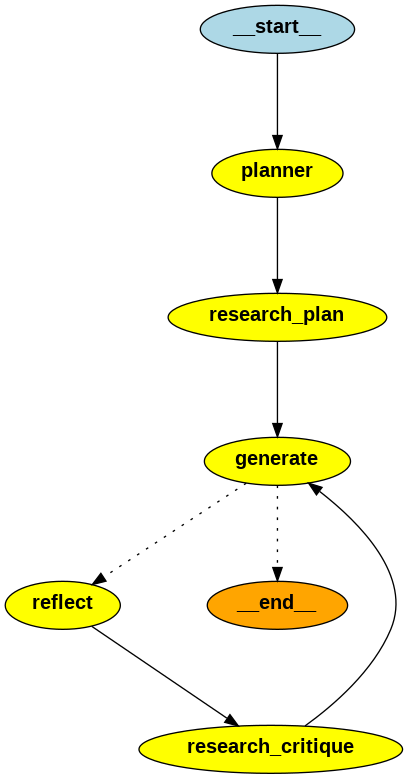

In [47]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

Let's now use this writing agent:

In [1]:
thread = {"configurable": {"thread_id": "7"}}
for s in graph.stream({
    "task": "Generate a recommendation paper for Google",
    "max_revisions": 3,
    "revision_number": 1,
}, thread):
    print(s)

NameError: name 'graph' is not defined

## LangChain resources to dive deeper in LangGraph
+ [LangChain introduction](https://python.langchain.com/v0.2/docs/introduction/)

+ GitHub repos for LangChain and LangGraph

## Conclusion and next steps

### Multiagent architecture

It is when multiple different agents work on the same shared state. The agents can be just a prompt and a language model (as we had in the Essay writer), or they could also have different tools (as in a prompt a language model and tools) and they could also have loops inside them.

![Multiagent arch](pics/multiagent.png)


### Supervisor agent

Here we have an agent that calls into some subagents and it controls the information that is given to each subagent, and each subagent has some isolated, non-shared state &mdash; they're graphs!

![Supervisor](pics/supervisor.png)

Doing the supervision requires a lot of intelligence, so it's common to delegate the supervision task to an LLM.

### Flow Engineering

It is a pipeline with certain loops. The idea is to think about what is the right information flow for your agents to take action.

An example is what we did with the essay writer in which we started with a Plan, and then we started executing actions on that plan and revise whether the plan has been successful.

![Plan and execute](pics/plan-and-execute.png)

### Language Agent Tree Search

This does a tree search over the state of possible actions:
1. Generate an action
2. Reflect and go down the tree based on that action,
3. Generate some other subactions based on that etc.

![Language Agent Tree Search](pics/language_agent_tree_search.png)